# Pipelined XGBoost & GridSearch - Titanic (Classification)

[Titanic - Machine Learning from Disaster](https://www.kaggle.com/competitions/titanic/data?select=train.csv)

[Titanic using Pipelined XGBoost & GridSearch](https://www.kaggle.com/code/maheshnanavare/titanic-using-pipelined-xgboost-gridsearch)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from math import ceil

In [3]:
!pip install xgboost

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
  Using cached xgboost-1.6.2-py3-none-manylinux2014_x86_64.whl (255.9 MB)
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/pytorch_p38/bin/python -m pip install --upgrade pip' command.


In [4]:
from sklearn.pipeline import Pipeline

# To perform operations on columns:
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

# ML algorithms:
from xgboost import XGBClassifier

# To evaluate performance model:
from sklearn.model_selection import GridSearchCV, ParameterGrid
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

In [79]:
# Read the data
X_y = pd.read_csv('./titanic/train.csv', index_col='PassengerId')
X_test = pd.read_csv('./titanic/test.csv', index_col='PassengerId')

X_y.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [ ]:
# Remove rows with missing target
X_y = X_y.dropna(axis=0, subset=['Survived'])

#  Separate target from predictors
y = X_y.Survived
X = X_y.drop(['Survived'], axis=1)

In [6]:
X.head(2)

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C


In [78]:
X_y

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S


In [80]:
y

PassengerId
1      0
2      1
3      1
4      1
5      0
      ..
887    0
888    1
889    0
890    1
891    0
Name: Survived, Length: 891, dtype: int64

In [7]:
def show_info(X,X_test):
    DataTypes = pd.DataFrame(X.dtypes.value_counts(),columns=['X'])
    DataTypes['X_test'] = X.dtypes.value_counts().values
    print("Number of Columns with different Data Types:\n")
    print(DataTypes,'\n')
    
    info = pd.DataFrame(X.dtypes, columns=['Dtype'])
    info['Unique_X'] = X.nunique().values
    info['Unique_X_test'] = X_test.nunique().values
    info['Null_X'] = X.isnull().sum().values
    info['Null_X_test'] = X_test.isnull().sum().values
    return info

In [8]:
show_info(X,X_test)

Number of Columns with different Data Types:

         X  X_test
object   5       5
int64    3       3
float64  2       2 



,Dtype,Unique_X,Unique_X_test,Null_X,Null_X_test
Pclass,int64,3,3,0,0
Name,object,891,418,0,0
Sex,object,2,2,0,0
Age,float64,88,79,177,86
SibSp,int64,7,7,0,0
Parch,int64,7,8,0,0
Ticket,object,681,363,0,0
Fare,float64,248,169,0,1
Cabin,object,147,76,687,327
Embarked,object,3,3,2,0


In [9]:
y.head(2)

PassengerId
1    0
2    1
Name: Survived, dtype: int64

# Data Cleaning¶

In [10]:
# Making function so that we can reuse it in later stages as well
def show_null_values(X, X_test):
    
    # Making DataFrame for combining training and testing missing values
    null_values = pd.DataFrame(X.isnull().sum(), columns=['Train Data'])
    null_values['Test Data'] = X_test.isnull().sum().values

    # Showing only columns having missing values and sorting them
    null_values = null_values.loc[(null_values['Train Data']!=0) | (null_values['Test Data']!=0)]
    null_values = null_values.sort_values(by=['Train Data','Test Data'],ascending=False)
    
    print("Total missing values:\n",null_values.sum(),'\n',sep='')
    
    return null_values

In [11]:
show_null_values(X, X_test)

Total missing values:
Train Data    866
Test Data     414
dtype: int64



,Train Data,Test Data
Cabin,687,327
Age,177,86
Embarked,2,0
Fare,0,1


In [12]:
# Show columns with more than half values missing
null_columns = [col for col in X.columns if X[col].isnull().sum() > X.shape[0]/2]
null_columns

['Cabin']

In [13]:
# Drop the above mentioned columns
X = X.drop(null_columns, axis=1)
X_test = X_test.drop(null_columns, axis=1)

# Data Visualization¶

In [14]:
Xy = X.copy()
Xy['Survived'] = y.copy()
correlation_matrix = Xy.corr()

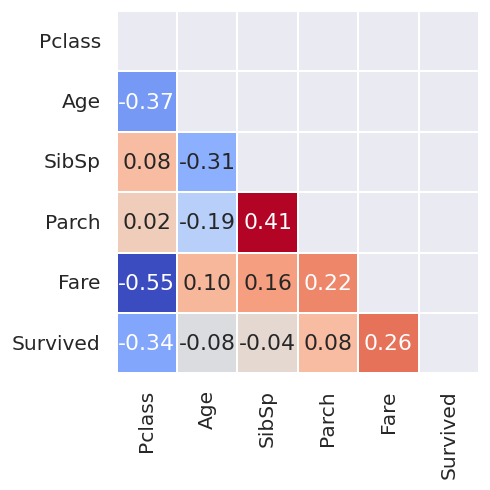

In [15]:
# Returns copy of array with upper part of the triangle (which will be masked/hidden)
mask = np.triu(correlation_matrix.corr())

sns.set(font_scale=1.1)
plt.figure(figsize=(4, 4), dpi=120)
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            square=True, mask=mask, linewidths=1, cbar=False)
plt.show()

### Sex vs Survived

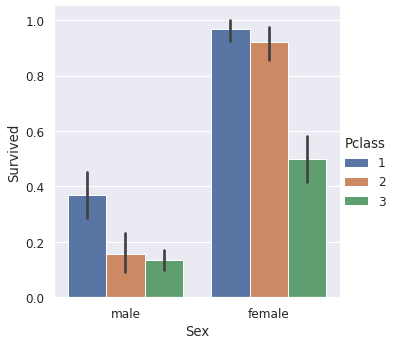

In [16]:
sns.catplot(data=Xy, x="Sex", y="Survived", hue="Pclass", kind="bar");

### Age vs Survived¶

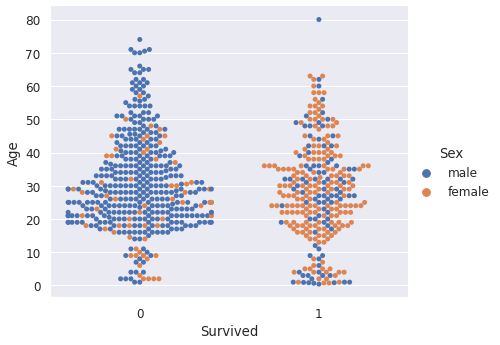

In [17]:
sns.catplot(data=Xy, y="Age", x="Survived", hue="Sex", kind="swarm", height=5, aspect=1.2);

### Fare vs Survived

(0.0, 300.0)

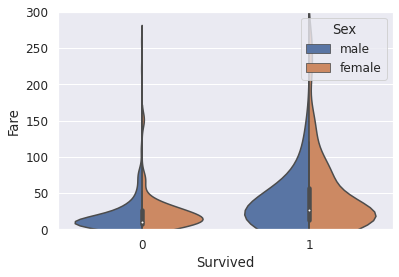

In [18]:
sns.violinplot(data=Xy, y="Fare", x="Survived", hue="Sex", split=True, height=10, aspect=1);
plt.ylim(0, 300)

### Feature Engineering

### Create New Categorical Features¶

### 1] Name Prefix

In [20]:
X['Prefix'] = X['Name'].str.split(expand=True)[1]
X_test['Prefix'] = X_test['Name'].str.split(expand=True)[1]

In [21]:
prefixes = X.Prefix.value_counts()
top_prefixes = prefixes[prefixes>len(X)/25].index
top_prefixes

Index(['Mr.', 'Miss.', 'Mrs.', 'Master.'], dtype='object')

In [22]:
X.Prefix = X.Prefix.apply(lambda x: x if x in top_prefixes else 'other')
X_test.Prefix = X_test.Prefix.apply(lambda x: x if x in top_prefixes else 'other')

In [23]:
df = pd.DataFrame(X['Prefix'].value_counts())
df['Prefix_test'] = X_test['Prefix'].value_counts().values
df

,Prefix,Prefix_test
Mr.,502,234
Miss.,179,77
Mrs.,121,70
other,49,19
Master.,40,18


### Imputing Age (using group means)

In [19]:
# Number of missing values in Age column
null_index=X.Age.isnull()
null_index_test=X_test.Age.isnull()
print(null_index.sum(),null_index_test.sum())

177 86


In [24]:
avg_ages = X.groupby(['Prefix','Pclass'])['Age'].mean().round()
pd.DataFrame(avg_ages)

Age
Prefix  Pclass      
Master. 1        5.0
        2        2.0
        3        5.0
Miss.   1       30.0
        2       22.0
        3       16.0
Mr.     1       42.0
        2       33.0
        3       29.0
Mrs.    1       42.0
        2       34.0
        3       34.0
other   1       42.0
        2       38.0
        3       29.0

In [25]:
for (i,k) in avg_ages.index:
    value=avg_ages.loc[i,k]
    X.loc[(X.Prefix==i) & (X.Pclass==k) & (X.Age.isnull()), ['Age']] = value
    X_test.loc[(X_test.Prefix==i) & (X_test.Pclass==k) & (X_test.Age.isnull()), ['Age']] = value

In [26]:
# Number of missing age values after imputation
print(X["Age"].isnull().sum(),X_test["Age"].isnull().sum())

0 0


In [27]:
# Rows where we imputed Age values
X[null_index].head(2)

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Prefix
PassengerId,,,,,,,,,,
6,3,"Moran, Mr. James",male,29.0,0,0,330877,8.4583,Q,Mr.
18,2,"Williams, Mr. Charles Eugene",male,33.0,0,0,244373,13.0000,S,Mr.


In [28]:
# Now, we will combine known prefixes as these categories are redundent when Sex column is present.
X.Prefix = X.Prefix.replace(['Mr.', 'Miss.', 'Mrs.', 'Master.'], 'known')
X_test.Prefix = X_test.Prefix.replace(['Mr.', 'Miss.', 'Mrs.', 'Master.'], 'known')

In [29]:
# We do not need 'Name' column anymore.
X = X.drop(['Name'], axis=1)
X_test = X_test.drop(['Name'], axis=1)

### 2] Age Category

In [30]:
def Age_categorise(df):
    df['Age_Cat'] = pd.cut(df.Age, bins = [0,10,40,60,100], labels = ['child','young','adult','senior'])
    
Age_categorise(X)
Age_categorise(X_test)
X['Age_Cat'].dtype

CategoricalDtype(categories=['child', 'young', 'adult', 'senior'], ordered=True)

In [31]:
df = pd.DataFrame(X['Age_Cat'].value_counts())
df['Age_Cat_test'] = X_test['Age_Cat'].value_counts().values
df

,Age_Cat,Age_Cat_test
young,644,307
adult,157,75
child,68,25
senior,22,11


### 3] Fare Categorym

In [33]:
X.Fare.describe()

count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64

In [34]:
def Fare_categorise(df):
    df['Fare_Cat'] = pd.qcut(df.Fare, q=4, labels = ['low','medium','high','very_high'])
    
Fare_categorise(X)
Fare_categorise(X_test)
X['Fare_Cat'].dtype

CategoricalDtype(categories=['low', 'medium', 'high', 'very_high'], ordered=True)

In [35]:
df = pd.DataFrame(X['Fare_Cat'].value_counts())
df['Fare_Cat_test'] = X_test['Fare_Cat'].value_counts().values
df

,Fare_Cat,Fare_Cat_test
medium,224,114
low,223,105
high,222,102
very_high,222,96


### 4] Family Size

In [37]:
X['Family'] = X['SibSp'] + X['Parch']
X_test['Family'] = X_test['SibSp'] + X_test['Parch']

X = X.drop(['SibSp','Parch'],axis=1)
X_test = X_test.drop(['SibSp','Parch'],axis=1)

In [38]:
X.Family.value_counts()

0     537
1     161
2     102
3      29
5      22
4      15
6      12
10      7
7       6
Name: Family, dtype: int64

In [39]:
def Categorize_Family(df):
    df['Family_Size'] = pd.cut(df.Family, bins = [-1,0.5,2.5,12], labels = ['alone', 'medium', 'large'])
    
Categorize_Family(X)
Categorize_Family(X_test)

In [40]:
df = pd.DataFrame(X['Family_Size'].value_counts())
df['Family_Size_test'] = X_test['Family_Size'].value_counts().values
df

,Family_Size,Family_Size_test
alone,537,253
medium,263,131
large,91,34


In [41]:
X.head(2)

,Pclass,Sex,Age,Ticket,Fare,Embarked,Prefix,Age_Cat,Fare_Cat,Family,Family_Size
PassengerId,,,,,,,,,,,
1,3,male,22.0,A/5 21171,7.2500,S,known,young,low,1,medium
2,1,female,38.0,PC 17599,71.2833,C,known,young,very_high,1,medium


In [42]:
X_test.head(2)

,Pclass,Sex,Age,Ticket,Fare,Embarked,Prefix,Age_Cat,Fare_Cat,Family,Family_Size
PassengerId,,,,,,,,,,,
892,3,male,34.5,330911,7.8292,Q,known,young,low,0,alone
893,3,female,47.0,363272,7.0000,S,known,adult,low,1,medium


### Data Visualization of Created Categories

In [43]:
# Concatenating X and y for Data Visualization purpose
Xy = X.copy()
Xy['Survived'] = y.copy()

In [44]:
# Making matplotlib parameters default
plt.rcParams.update(plt.rcParamsDefault)

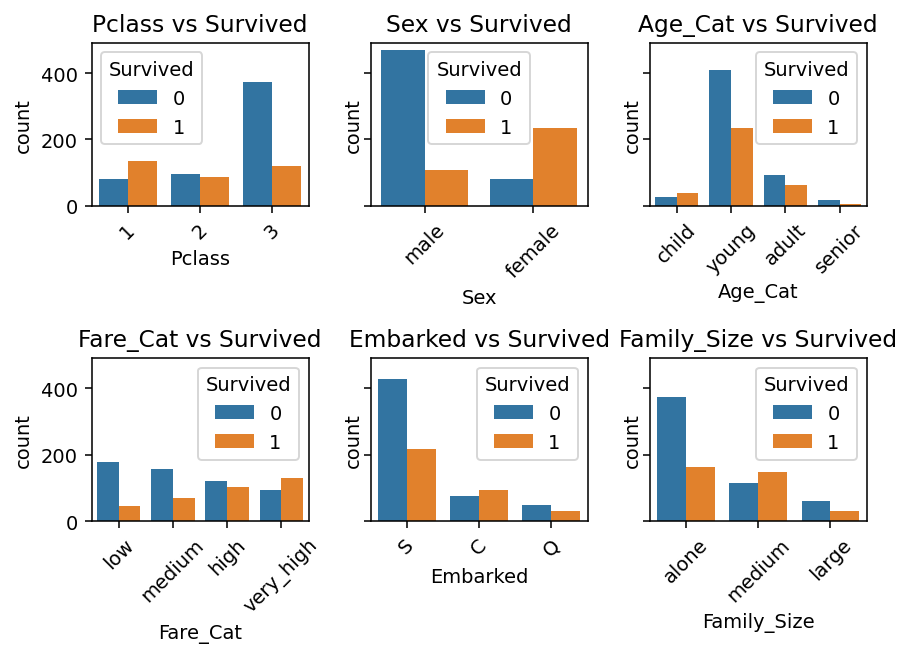

In [45]:
l=['Pclass','Sex','Age_Cat','Fare_Cat','Embarked','Family_Size']
figure, axes = plt.subplots(nrows=2, ncols=3, sharey=True, sharex=False, dpi=140)
index = 0
axes = axes.flatten()
for axis in axes:
    sns.countplot(x = l[index], hue = "Survived", data = Xy, ax=axis)
    axis.set_title(l[index]+' vs Survived')
    index = index+1
    plt.tight_layout()
    for tick in axis.get_xticklabels():
        tick.set_rotation(45)
plt.show()

### 6) Feature Selection

In [46]:
# We used Categorical columns Age_Cat, Fare_Cat, Family_Size for visualizations only. So, drop original columns.
X = X.drop(['Age_Cat','Fare_Cat','Family_Size'],axis=1)
X_test = X_test.drop(['Age_Cat','Fare_Cat','Family_Size'],axis=1)

In [47]:
# Select categorical columns with low cardinality (number of unique values in a column)
categorical_cols = [cname for cname in X.columns 
                    if X[cname].nunique() < 10 and
                    X[cname].dtype in ["object","category"]]

In [48]:
# Select numerical columns
numerical_cols = [cname for cname in X.columns 
                  if X[cname].dtype in ['int64', 'float64']]

In [49]:
# Keep selected columns only
my_cols = categorical_cols + numerical_cols
X = X[my_cols]
X_test = X_test[my_cols]

### Final X and X_test on which regression model will be trained

In [50]:
print(len(categorical_cols),len(numerical_cols))

3 4


In [51]:
X_test.head(2)

,Sex,Embarked,Prefix,Pclass,Age,Fare,Family
PassengerId,,,,,,,
892,male,Q,known,3,34.5,7.8292,0
893,female,S,known,3,47.0,7.0000,1


In [52]:
show_info(X,X_test)

Number of Columns with different Data Types:

         X  X_test
object   3       3
int64    2       2
float64  2       2 



,Dtype,Unique_X,Unique_X_test,Null_X,Null_X_test
Sex,object,2,2,0,0
Embarked,object,3,3,2,0
Prefix,object,2,2,0,0
Pclass,int64,3,3,0,0
Age,float64,88,79,0,0
Fare,float64,248,169,0,1
Family,int64,9,9,0,0


## 7) Model Creation

### Preprocessing Pipelines

In [55]:
# Preprocessing for numerical data
numerical_transformer = SimpleImputer(strategy='median')

In [56]:
# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

In [57]:
# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

### Model Pipeline

In [59]:
# Create object of XGBClassifier class
xgb = XGBClassifier()

# Bundle preprocessing and modeling code in a pipeline
classifier = Pipeline(steps=[('preprocessor', preprocessor),
                      ('model', xgb)
                     ])

### Visualize the pipeline

In [60]:
from sklearn import set_config
set_config(display='diagram')
classifier

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  SimpleImputer(strategy='median'),
                                                  ['Pclass', 'Age', 'Fare',
                                                   'Family']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Sex', 'Embarked',
                                                   'Prefix'])])),
                ('model',
                 XGBClassifier(base_score=None, booster=None, c...
                               gamma=None, gpu_id=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=None,
                               max_leaves=None, min_child_weight=None,
                               missing=nan, monotone_constraints=None,
                               n_estimators=100, n_jobs=None,
                               num_parallel_tree=None, predictor=None,
                               random_state=None, reg_alpha=None,
                               reg_lambda=None, ...))])

### 8) Training and Testing Model

### Grid Search & Cross Validation

In [62]:
param_grid = [
    {
        "model__reg_lambda": [50],
        "model__subsample": [0.6],
        "model__learning_rate": [0.3, 0.4],
        "model__n_estimators": [50, 100],
        "model__max_depth": [4]
    }
]
grid_search = GridSearchCV(classifier, param_grid, cv=3, verbose=1)
grid_search.fit(X, y);

Fitting 3 folds for each of 4 candidates, totalling 12 fits


In [63]:
print("Best params:",grid_search.best_params_,sep='\t',end='\n\n')
print("Best score in grid search:",round(grid_search.best_score_,3),sep='\t')
print("Score on whole trained data:",round(grid_search.score(X, y),3),sep='\t')

Best params:	{'model__learning_rate': 0.4, 'model__max_depth': 4, 'model__n_estimators': 100, 'model__reg_lambda': 50, 'model__subsample': 0.6}

Best score in grid search:	0.832
Score on whole trained data:	0.877


In [64]:
# Top 5 parameter combinations
df = pd.DataFrame(grid_search.cv_results_)
display(df.sort_values('rank_test_score')[:5])

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__learning_rate,param_model__max_depth,param_model__n_estimators,param_model__reg_lambda,param_model__subsample,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
3,0.429141,0.007798,0.008721,0.000142,0.4,4,100,50,0.6,"{'model__learning_rate': 0.4, 'model__max_dept...",0.811448,0.855219,0.828283,0.831650,0.018027,1
0,0.262478,0.058886,0.009648,0.001512,0.3,4,50,50,0.6,"{'model__learning_rate': 0.3, 'model__max_dept...",0.814815,0.838384,0.821549,0.824916,0.009912,2
2,0.286026,0.047347,0.009490,0.000309,0.4,4,50,50,0.6,"{'model__learning_rate': 0.4, 'model__max_dept...",0.811448,0.841751,0.821549,0.824916,0.012598,2
1,0.423511,0.006290,0.010887,0.003106,0.3,4,100,50,0.6,"{'model__learning_rate': 0.3, 'model__max_dept...",0.804714,0.841751,0.824916,0.823793,0.015141,4


### Feature Importance

In [65]:
Feature_Imp = grid_search.best_estimator_.named_steps["model"].feature_importances_
Feature_Imp

array([0.17459273, 0.04544534, 0.04137103, 0.05820287, 0.54215163,
       0.        , 0.03189174, 0.03236162, 0.04874951, 0.02523354,
       0.        ], dtype=float32)

In [66]:
# Predicting y for trained data
y_pred = grid_search.predict(X)

In [67]:
# Checking trainig data without preprocessing (features, actual target and predicted target)
Xyy = pd.DataFrame(X.copy())
Xyy['Actual_Survived'] = y
Xyy['Predicted_Survived'] = y_pred
Xyy.head(2)

,Sex,Embarked,Prefix,Pclass,Age,Fare,Family,Actual_Survived,Predicted_Survived
PassengerId,,,,,,,,,
1,male,S,known,3,22.0,7.2500,1,0,0
2,female,C,known,1,38.0,71.2833,1,1,1


In [68]:
# Preprocessed (Imputed and OneHotCoded) Training and Test data using Pipeline
column_values = ['Pclass','Age','Fare','Family','Sex_female','Sex_male','Embarked_C','Embarked_Q','Embarked_S','Prefix_known','Prefix_other']
X_processed = pd.DataFrame(grid_search.best_estimator_.named_steps["preprocessor"].transform(X), columns = column_values)
X_processed.head(2)

,Pclass,Age,Fare,Family,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Prefix_known,Prefix_other
0,3.0,22.0,7.2500,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
1,1.0,38.0,71.2833,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0


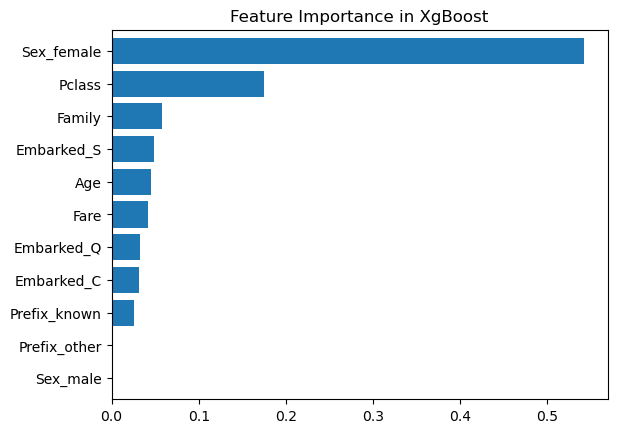

In [69]:
ax =pd.Series(Feature_Imp,X_processed.columns).sort_values(ascending=True).plot.barh(width=0.8)
ax.set_title('Feature Importance in XgBoost')
plt.show()

### Confusion Matrix (for training data)

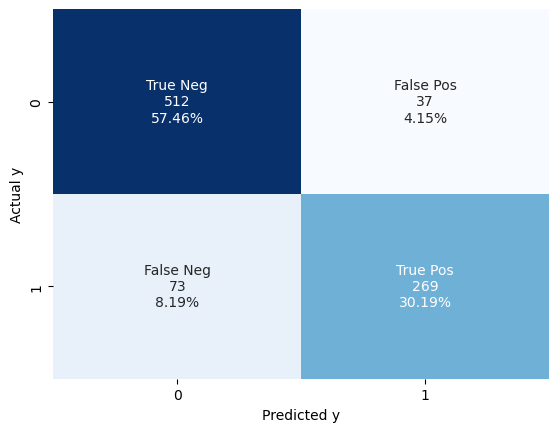

In [70]:
# Credit: 'https://medium.com/@dtuk81/confusion-matrix-visualization-fc31e3f30fea'
cm = confusion_matrix(y, y_pred)

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in cm.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in cm.flatten()/np.sum(cm)]

labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(cm, annot=labels, fmt='', cmap='Blues', cbar=False)
ax.set_xticklabels(['0','1'])
ax.set_yticklabels(['0','1'])
ax.set(ylabel="Actual y", xlabel="Predicted y");

### Classification Report (for training data)

In [72]:
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.93      0.90       549
           1       0.88      0.79      0.83       342

    accuracy                           0.88       891
   macro avg       0.88      0.86      0.87       891
weighted avg       0.88      0.88      0.88       891



In [73]:
# Model Evaluation metrics 
print('Accuracy Score : ' + str(accuracy_score(y,y_pred).round(3)))
print('Precision Score : ' + str(precision_score(y,y_pred).round(3)))
print('Recall Score : ' + str(recall_score(y,y_pred).round(3)))
print('F1 Score : ' + str(f1_score(y,y_pred).round(3)))

Accuracy Score : 0.877
Precision Score : 0.879
Recall Score : 0.787
F1 Score : 0.83


### 9) Predicting y

In [74]:
# Generate test predictions
preds_test = grid_search.predict(X_test)

In [75]:
# Checking testing data with features and predicted target
Xy = X_test.copy()
Xy['Survived'] = preds_test.copy()
Xy.head(2)

,Sex,Embarked,Prefix,Pclass,Age,Fare,Family,Survived
PassengerId,,,,,,,,
892,male,Q,known,3,34.5,7.8292,0,0
893,female,S,known,3,47.0,7.0000,1,0


In [76]:
# Save output to CSV file
output = pd.DataFrame({'PassengerId': X_test.index,
                       'Survived': preds_test})
output.to_csv('submission.csv', index=False)

In [77]:
# Submit results
submission_data = pd.read_csv("submission.csv")
submission_data.head(2)

,PassengerId,Survived
0,892,0
1,893,0
